# Tutorial for ReVeaL usage and example downstream analytics

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys, re
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import shutil

## Read in data

For the purposes of this tutorial, the example data is WES from TCGA for prostate and breast cancer patients for sake of file size and because they are non-controlled data.  

However ReVeaL's true application is for WGS data where alterations in the non-genic regions are less well characterized.

We have placed simplified MAF files here on Box.  Please download and unzip in your working directory.
https://ibm.box.com/s/3diwam9jup3o1k47e1dyg2iw80b8qzju

In [3]:
tcga_prad = pd.read_csv( 'TCGA_PRAD_maf_select.csv' )
tcga_brca = pd.read_csv( 'TCGA_BRCA_maf_select.csv' )


## Formatting for ReVeaL

In [76]:
tcga_prad_format = tcga_prad[[ 'patient_barcode', 'Chromosome', 'Start_Position', 'End_Position' ]] 
tcga_prad_format.loc[tcga_prad_format.index,'Chromosome'] = list( tcga_prad_format['Chromosome'].map( lambda x: re.sub( 'chr', '', str(x) ) ) )
tcga_prad_format.columns = [ 'samples', 'chr', 'start', 'stop' ]

tcga_brca_format = tcga_brca[[ 'patient_barcode', 'Chromosome', 'Start_Position', 'End_Position' ]] 
tcga_brca_format.loc[tcga_brca_format.index,'Chromosome'] = list( tcga_brca_format['Chromosome'].map( lambda x: re.sub( 'chr', '', str(x) ) ) )
tcga_brca_format.columns = [ 'samples', 'chr', 'start', 'stop' ]

tcga_reveal_input = pd.concat( [ tcga_prad_format, tcga_brca_format ] )
tcga_reveal_input = tcga_reveal_input[tcga_reveal_input['chr'].isin(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22'])].drop_duplicates()
tcga_reveal_input.to_csv( 'TCGA_maf_ReVealInput.tsv', sep = '\t', index = False )

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X',
       'Y', 'M'], dtype=object)

In [88]:
tcga_reveal_input[tcga_reveal_input['samples']=='TCGA-CH-5740'].head()

,samples,chr,start,stop
876473,TCGA-CH-5740,1,943689,943689
876474,TCGA-CH-5740,1,943728,943728
876475,TCGA-CH-5740,1,944918,944918
876476,TCGA-CH-5740,1,1050282,1050282
876477,TCGA-CH-5740,1,1051505,1051505


In [84]:
# Make Labels File
tcga_labels = pd.DataFrame( list(zip( tcga_reveal_input['samples'].to_list(), ['PRAD'] * len(tcga_reveal_input) ) ) )
tcga_labels.columns = [ 'samples', 'phenotype' ]
tcga_labels.loc[ tcga_labels['samples'].isin( tcga_brca_format['samples'].to_list() ), 'phenotype'] = 'BRCA'
tcga_labels.to_csv( 'TCGA_labels_ReVealInput.csv', index = False )

In [85]:
# Make the Train Test File
tcga_trainTest = pd.DataFrame( [ ['PRAD', 'BRCA'], [10,10], [5,5] ] ).transpose()
tcga_trainTest.columns = [ 'phenotype', 'Train', 'Test' ]
tcga_trainTest.to_csv( 'TCGA_trainTest_ReVealInput.csv', index = False )

In [87]:
tcga_labels

,samples,phenotype
0,TCGA-HI-7169,PRAD
1,TCGA-HI-7169,PRAD
2,TCGA-HI-7169,PRAD
3,TCGA-HI-7169,PRAD
4,TCGA-HI-7169,PRAD
...,...,...
10696199,TCGA-C8-A27A,BRCA
10696200,TCGA-C8-A27A,BRCA
10696201,TCGA-C8-A27A,BRCA
10696202,TCGA-C8-A27A,BRCA


In [8]:
# Load the Regions File
region_file_genic = '../regions/genic.txt'
region_genic = pd.read_csv( region_file_genic, sep = '\t')
region_genic.head()

,chr,start,stop,extra
0,1,65419,71585,"gene_id ""OR4F5""; transcript_id """"; db_xref ""Ge..."
1,1,450740,451678,"gene_id ""OR4F29""; transcript_id """"; db_xref ""G..."
2,1,923923,944574,"gene_id ""SAMD11""; transcript_id """"; db_xref ""G..."
3,1,944203,959256,"gene_id ""NOC2L""; transcript_id """"; db_xref ""Ge..."
4,1,975198,982093,"gene_id ""PERM1""; transcript_id """"; db_xref ""Ge..."


## Running ReVeaL to create shingles

In [116]:
import geno4sd.ml_tools.ReVeaL as rv

In [93]:
sample_info = pd.read_csv("TCGA_maf_ReVealInput.tsv", sep='\t')
chromosomes = sample_info['chr'].unique()
regions = pd.read_csv("../regions/genic.txt", sep='\t')

In [12]:
os.mkdir("test")

In [94]:
# compute the mutational load
chr_interest = 1
mut_load_chr1 = rv.compute_mutational_load(sample_info[sample_info['chr'] == chr_interest], sample_info['samples'].unique(), regions[regions['chr'] == chr_interest], chr_interest)

In [ ]:
# Generate 5 folds of the train and test sampling 25 patient to generate the shingle 
train_samples, test_samples = rv.train_test_split(tcga_labels, tcga_trainTest, 5, 25)

# Making Genic Shingles
shingle_chr1 = rv.compute_shingle(train_samples, test_samples, mut_load_chr1, 1)

In [ ]:
#Alternatively instead to compute the mutation load and shingle singularly the compute function can be used
chromosomes = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22']
shingles = rv.compute(sample_info, tcga_labels, tcga_trainTest, region_genic, chromosomes, 5, 25, 'test')

## Running example shingles

Let's read in some pre-computed shingles for from WGS of 717 blood cancer patients diagnosed with either AML, B-ALL, CLL, CML, CMML, MDS, or PMF.

We will perform standard machine learning approaches but any ML/AI technique may be applied with the understanding that the performance metric of choice will represent a concept more analygous to hertiability than predictive power for any given feature.

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

def example_reveal_learning( dataFile ):
    dat = pd.read_csv( dataFile, index_col = 0 )
    dat_labels = pd.DataFrame( [ x.split('_') for x in dat.index ], columns = ['sample', 'phenotype', 'fold', 'trainTest' ], index = dat.index )

    folds = list(set(dat_labels.fold))
    phenotypes = list(set(dat_labels.phenotype))

    perf = []
    for f in folds:
        labels_toLearn = dat_labels[ dat_labels.fold == f ] 

        # Get the train and test sets
        train_X = dat.loc[ labels_toLearn[ labels_toLearn.trainTest == 'Train' ].index ]
        train_y = labels_toLearn[ labels_toLearn.trainTest == 'Train'][ 'phenotype' ].to_list()
        test_X = dat.loc[ labels_toLearn[ labels_toLearn.trainTest == 'Test' ].index ]
        test_y = labels_toLearn[ labels_toLearn.trainTest == 'Test'][ 'phenotype' ].to_list()

        # RF classifier
        clf = RandomForestClassifier(max_depth=None, random_state=0, n_estimators = 500, n_jobs = -1)
        clf.fit(train_X, train_y)
        y_pred = clf.predict(test_X)

        # F1 score
        res = [f1_score( test_y, y_pred, average = 'weighted' ) ]
        for pheno in phenotypes:
            res.append( f1_score( test_y, y_pred, labels = [pheno], average = 'weighted' ) )
        
        
        perf.append( [f] + res )
    perf = pd.DataFrame( perf, columns = ['Fold', 'Multiclass'] + phenotypes )

    return perf
    

### Running CDS regions

In [16]:
# Unzip the CDS data
if not os.path.isdir('CDS'):
    shutil.unpack_archive('CDS.tar.gz', '.')

In [17]:
cds_files = [ x for x in os.listdir( 'CDS' ) if ( 'Perm' not in x ) ]
leu_cds_perf = []
for fl in cds_files:
    res = example_reveal_learning(os.path.join( 'CDS', fl ) )
    res.loc[ res.index, 'File' ] = [fl] * len(res)
    leu_cds_perf.append(res)    


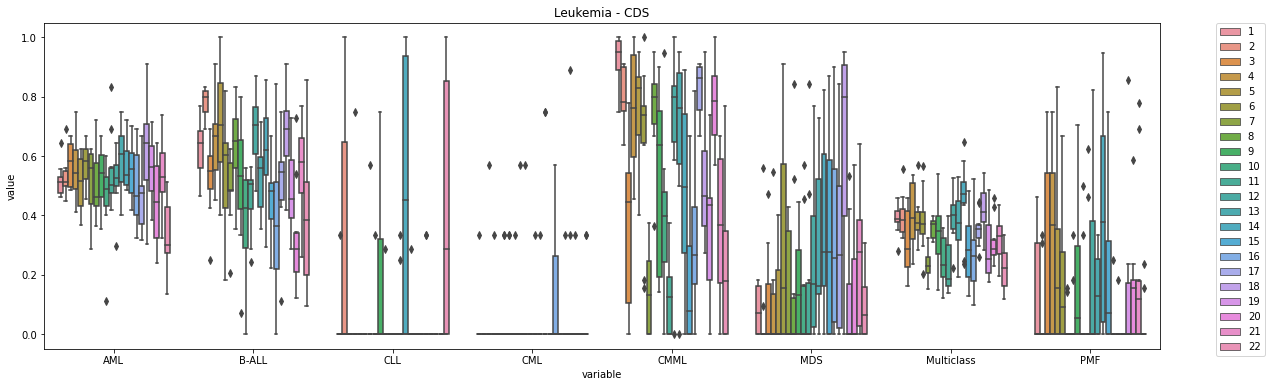

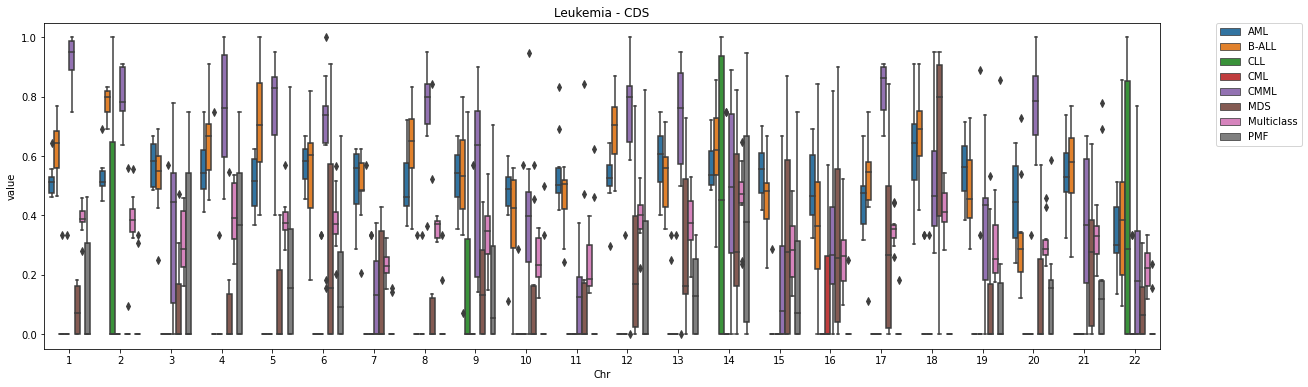

In [18]:
leu_cds_perf_df = pd.concat( leu_cds_perf )
leu_cds_perf_df = leu_cds_perf_df.reset_index(drop=True)
leu_cds_perf_df.loc[ leu_cds_perf_df.index, 'Chr' ] = leu_cds_perf_df['File'].map( lambda x: int( re.sub( '-.*', '', re.sub( '^.*Chr', '', x ) ) ) )
leu_cds_perf_df = leu_cds_perf_df.melt( id_vars = ['File', 'Fold', 'Chr'] )
leu_cds_perf_df = leu_cds_perf_df.sort_values('Chr')
leu_cds_perf_df = leu_cds_perf_df.sort_values('variable')

plt.figure( figsize = (20,6) )
sns.boxplot( data = leu_cds_perf_df, x = 'variable', y = 'value', hue = 'Chr' )
plt.title( 'Leukemia - CDS' )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()
plt.close()

plt.figure( figsize = (20,6) )
sns.boxplot( data = leu_cds_perf_df, x = 'Chr', y = 'value', hue = 'variable' )
plt.title( 'Leukemia - CDS' )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()
plt.close()

## Running non-coding, unannotated regions

In [18]:
# Unzip the Dark data
if not os.path.isdir('Dark'):
    shutil.unpack_archive('Dark.tar.gz', '.')

In [19]:

dark_files = [ x for x in os.listdir( 'Dark' ) if ( 'Perm' not in x ) ]
leu_dark_perf = []
for fl in dark_files:
    res = example_reveal_learning(os.path.join( 'Dark', fl ) )
    res.loc[ res.index, 'File' ] = [fl] * len(res)
    leu_dark_perf.append(res)


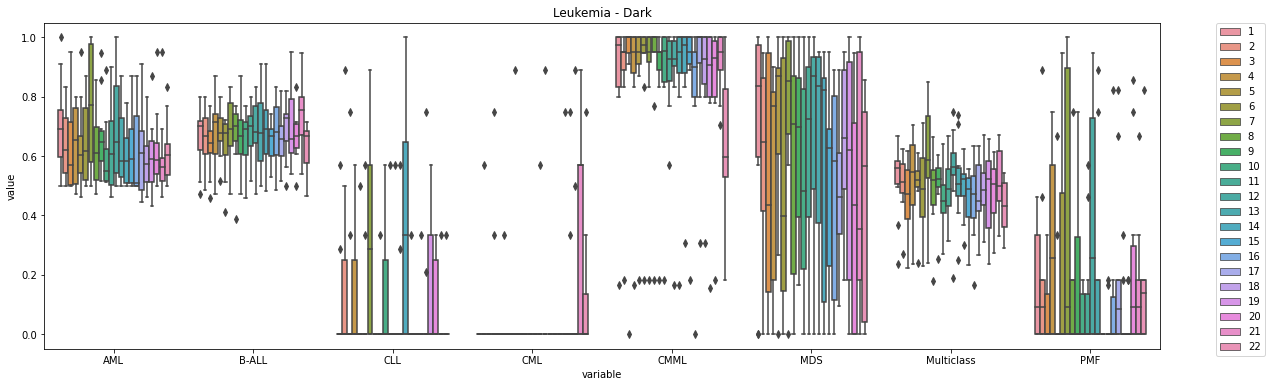

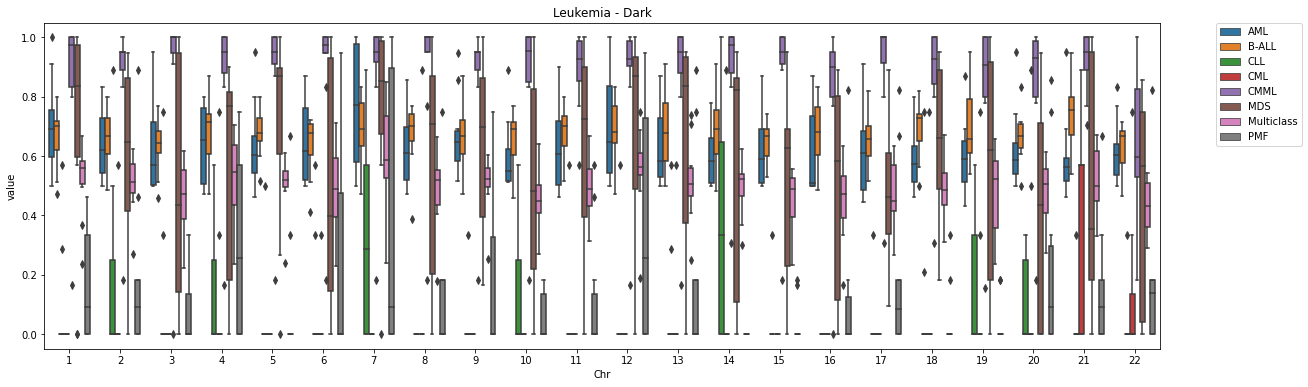

In [20]:
leu_dark_perf_df = pd.concat( leu_dark_perf )
leu_dark_perf_df = leu_dark_perf_df.reset_index(drop=True)
leu_dark_perf_df.loc[ leu_dark_perf_df.index, 'Chr' ] = leu_dark_perf_df['File'].map( lambda x: int( re.sub( '-.*', '', re.sub( '^.*Chr', '', x ) ) ) )
leu_dark_perf_df = leu_dark_perf_df.melt( id_vars = ['File', 'Fold', 'Chr'] )
leu_dark_perf_df = leu_dark_perf_df.sort_values('Chr')
leu_dark_perf_df = leu_dark_perf_df.sort_values('variable')

plt.figure( figsize = (20,6) )
sns.boxplot( data = leu_dark_perf_df, x = 'variable', y = 'value', hue = 'Chr' )
plt.title( 'Leukemia - Dark' )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()
plt.close()

plt.figure( figsize = (20,6) )
sns.boxplot( data = leu_dark_perf_df, x = 'Chr', y = 'value', hue = 'variable' )
plt.title( 'Leukemia - Dark' )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()
plt.close()

## Running whole genome

In [21]:
# Unpack the Whole Genome region files
if not os.path.isdir('WG'):
    shutil.unpack_archive('WG.tar.gz', '.')

In [22]:

wg_files = [ x for x in os.listdir( 'WG' ) if ( 'Perm' not in x ) ]
leu_wg_perf = []
for fl in wg_files:
    res = example_reveal_learning(os.path.join( 'WG', fl ) )
    res.loc[ res.index, 'File' ] = [fl] * len(res)
    leu_wg_perf.append(res)


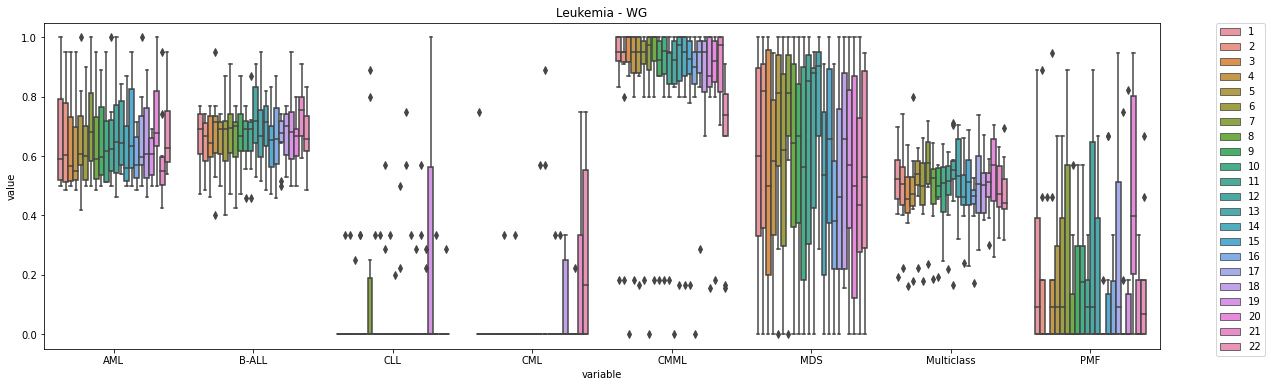

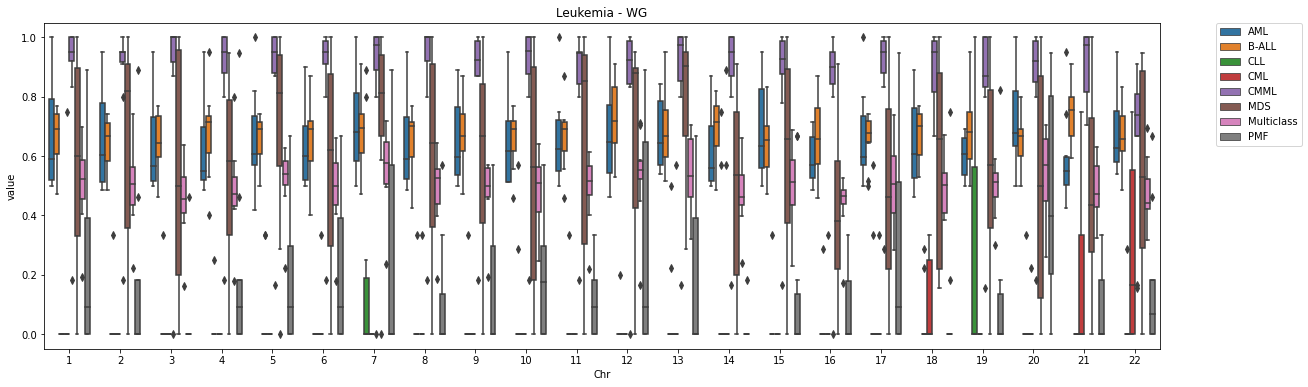

In [23]:
leu_wg_perf_df = pd.concat( leu_wg_perf )
leu_wg_perf_df = leu_wg_perf_df.reset_index(drop=True)
leu_wg_perf_df.loc[ leu_wg_perf_df.index, 'Chr' ] = leu_wg_perf_df['File'].map( lambda x: int( re.sub( '-.*', '', re.sub( '^.*Chr', '', x ) ) ) )
leu_wg_perf_df = leu_wg_perf_df.melt( id_vars = ['File', 'Fold', 'Chr'] )
leu_wg_perf_df = leu_wg_perf_df.sort_values('Chr')
leu_wg_perf_df = leu_wg_perf_df.sort_values('variable')

plt.figure( figsize = (20,6) )
sns.boxplot( data = leu_wg_perf_df, x = 'variable', y = 'value', hue = 'Chr' )
plt.title( 'Leukemia - WG' )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()
plt.close()

plt.figure( figsize = (20,6) )
sns.boxplot( data = leu_wg_perf_df, x = 'Chr', y = 'value', hue = 'variable' )
plt.title( 'Leukemia - WG' )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()
plt.close()